In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import xtarfile as tarfile
import cv2
import pickle

2022-10-17 10:14:06.356920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 10:14:06.357001: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-17 10:14:06.764450: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 10:14:24.972357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-17 10:14:24.976216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
train_data = 'Sativa_AS/training.gz'
test_data = 'Sativa_AS/test.gz'

In [3]:
import numpy as np
import os
# Read photos
all_photos_train = []

# tqdm in used to show progress bar while reading the data in a notebook here, you can change
# tqdm_notebook to use it outside a notebook
sativa_ILs = os.listdir("Sativa_AS/training")
for m in sativa_ILs:
    img = cv2.imread("Sativa_AS/training/" + m)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Crop only faces and resize it
    #img = img[dy:-dy, dx:-dx]
    img = cv2.resize(img, (400, 500))

    all_photos_train.append(img)

all_photos_train = np.stack(all_photos_train).astype('uint8')

In [4]:
# Read photos
all_photos_test = []

# tqdm in used to show progress bar while reading the data in a notebook here, you can change
# tqdm_notebook to use it outside a notebook
sativa_ILs = os.listdir("Sativa_AS/test")
for m in sativa_ILs:
    img = cv2.imread("Sativa_AS/test/" + m)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Crop only faces and resize it
    #img = img[dy:-dy, dx:-dx]
    img = cv2.resize(img, (400, 500))

    all_photos_test.append(img)

all_photos_test = np.stack(all_photos_test).astype('uint8')

In [5]:
all_photos_train = all_photos_train.astype('float32') / 255.0 - 0.5
all_photos_test = all_photos_test.astype('float32') / 255.0 - 0.5

In [6]:
print(all_photos_train.max(), all_photos_test.min())

0.5 -0.5


In [10]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

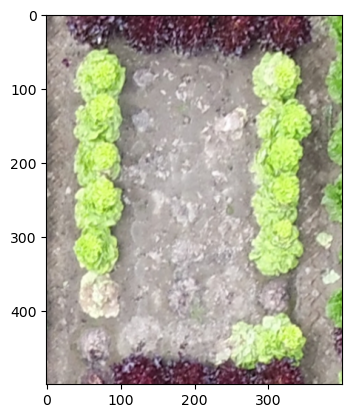

In [11]:
show_image(all_photos_test[0])

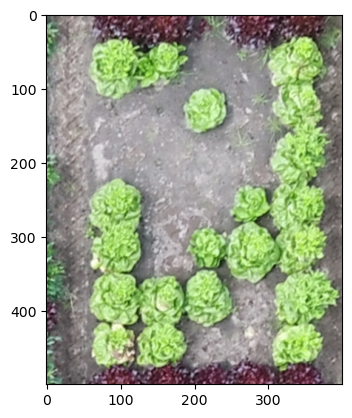

In [12]:
show_image(all_photos_train[0])

In [7]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [11]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = all_photos_test.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 2)

2022-10-14 17:02:44.184129: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at cwise_ops_common.h:137 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[2,600000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[2,600000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [11]:
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500, 400, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 7)                 4200007   
                                                                 
 sequential_3 (Sequential)   (None, 500, 400, 3)       4800000   
                                                                 
Total params: 9,000,007
Trainable params: 9,000,007
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
autoencoder.fit(x=all_photos_train, y=all_photos_train, epochs=32,
                validation_data=[all_photos_test, all_photos_test])

### Analyse the model

In [1]:
from keras.models import load_model
model1 = load_model('autoencoder_model_test.h5')

2022-10-17 12:10:58.659800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 12:10:58.728414: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
